# Effect Classification

In [39]:
import torch
import torchaudio
import os

#### Add Tensorboard to record data

In [40]:
from torch.utils.tensorboard import SummaryWriter

EXPERIMENT_NAME = "c53_classify"
LOG_DIR = "_log/" + EXPERIMENT_NAME

if not os.path.exists('%s' % LOG_DIR):
    os.makedirs('%s' % LOG_DIR)

log_writer = SummaryWriter(LOG_DIR)


### Load dataset

Using device cpu
There are 8250 samples in the dataset.
Shape of signal: torch.Size([1, 64, 64])
input feature:


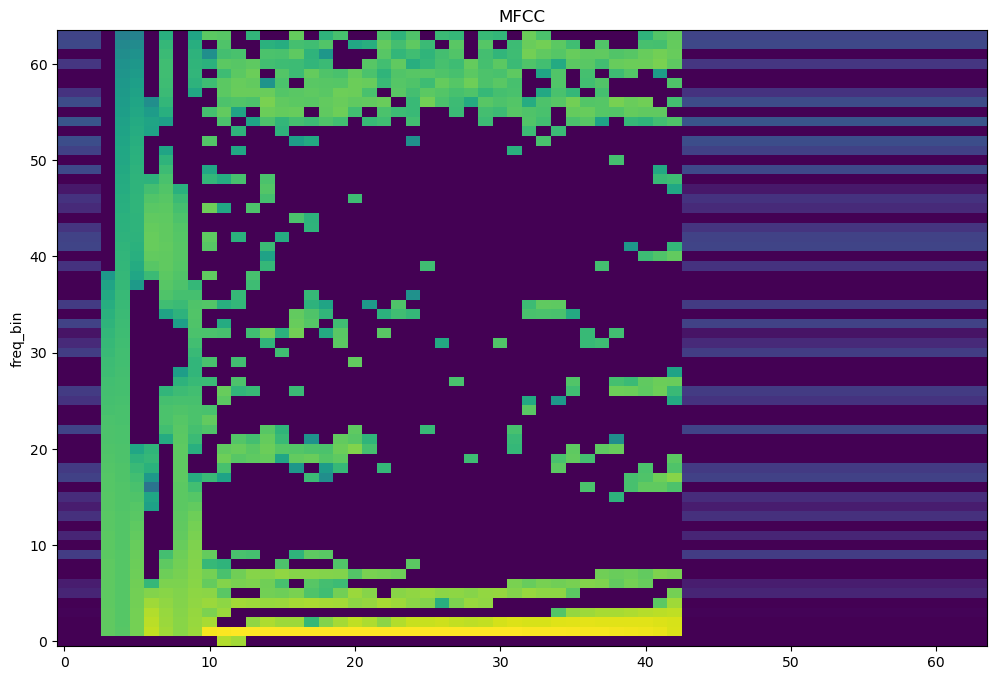

In [41]:
from src.gtfxdataset import GtFxDataset
from src.util import plot_spectrogram

AUDIO_DIR = "_assets/DATASET/GT-FX-C53/"
ANNOTATIONS_FILE = os.path.join(AUDIO_DIR, "annotation.csv")

SAMPLE_RATE = 22050
NUM_SAMPLES = 22050*3

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using device {device}")

mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=512,
    hop_length=1050,
    n_mels=64,
    # power=2
)

spectrogram = torchaudio.transforms.Spectrogram(
    power=2,
    n_fft=127,
    win_length= 127,
    hop_length= 1040,
    normalized=True
)

mfcc = torchaudio.transforms.MFCC(
    sample_rate = SAMPLE_RATE, 
    n_mfcc = 64,
    melkwargs = {
        "n_fft": 1024,
        "hop_length": 1030,
        "n_mels": 64,
        "center": False})

fxData = GtFxDataset(ANNOTATIONS_FILE,
                        AUDIO_DIR,
                        mfcc,
                        SAMPLE_RATE,
                        NUM_SAMPLES,
                        device)

signal, _, _, _, filename = fxData[0]
print(f"There are {len(fxData)} samples in the dataset.")
print(f"Shape of signal: {signal.shape}")

print("input feature:")
log_writer.add_figure("Input Feature", plot_spectrogram(signal[0], title="MFCC"))

#### Split dataset into train and test sets

In [42]:
from src.classifier import train

BATCH_SIZE = round(len(fxData) / 200)

split_ratio = [0.8, 0.1, 0.1]
train_set, test_set, val_set = torch.utils.data.random_split(fxData, lengths=split_ratio)

train_dataloader = train.create_data_loader(train_set, BATCH_SIZE)
test_dataloader = train.create_data_loader(test_set, BATCH_SIZE)
val_dataloader = train.create_data_loader(val_set, BATCH_SIZE)

#### Model training

In [43]:
from src.classifier import model
from torch import nn

LEARNING_RATE = 0.001
EPOCHS = 20

# construct model and assign it to device
cnn = model.Classifier().to(device)

log_writer.add_graph(cnn, signal.unsqueeze_(0))

# initialise loss funtion + optimiser
loss_fn = nn.BCEWithLogitsLoss()
optimiser = torch.optim.Adam(cnn.parameters(), lr=LEARNING_RATE)

# train model
train.train(cnn,
            train_dataloader,
            test_dataloader,
            loss_fn,
            optimiser,
            device,
            log_writer,
            EPOCHS)


c:\Users\roger\miniconda3\envs\torchaudio\lib\site-packages\torch\jit\_trace.py:1056: TracerWarning: Encountering a list at the output of the tracer might cause the trace to be incorrect, this is only valid if the container structure does not change based on the module's inputs. Consider using a constant container instead (e.g. for `list`, use a `tuple` instead. for `dict`, use a `NamedTuple` instead). If you absolutely need this and know the side effects, pass strict=False to trace() to allow this behavior.
  module._c._create_method_from_trace(


Epoch 1
loss: 3.522509  [  0/6600]
loss: 2.398160  [820/6600]
loss: 2.238276  [1640/6600]
loss: 2.023072  [2460/6600]
loss: 1.435153  [3280/6600]
loss: 1.936183  [4100/6600]
loss: 1.546457  [4920/6600]
loss: 1.449807  [5740/6600]
loss: 1.459785  [6560/6600]
distortion: Accuracy: 99.6%, avg loss: 0.031416
chorus: Accuracy: 64.1%, avg loss: 0.642634
tremolo: Accuracy: 71.2%, avg loss: 0.582769
delay: Accuracy: 89.0%, avg loss: 0.317039
reverb: Accuracy: 95.9%, avg loss: 0.145370
Total: avg loss: 1.719228
learning rate: 0.001000 -> 0.000910
---------------------------

Epoch 2
loss: 1.496227  [  0/6600]
loss: 1.356175  [820/6600]
loss: 1.071001  [1640/6600]
loss: 1.125438  [2460/6600]
loss: 1.395823  [3280/6600]
loss: 1.295504  [4100/6600]
loss: 1.341352  [4920/6600]
loss: 0.924027  [5740/6600]
loss: 1.280962  [6560/6600]
distortion: Accuracy: 99.5%, avg loss: 0.030437
chorus: Accuracy: 74.3%, avg loss: 0.530183
tremolo: Accuracy: 80.6%, avg loss: 0.382997
delay: Accuracy: 92.6%, avg loss

#### Save model weight and bias

In [44]:
WEIGHTS_DIR = "_weights/"
WEIGHTS_FILE = os.path.join(WEIGHTS_DIR, EXPERIMENT_NAME + ".pth")

if not os.path.exists('%s' % WEIGHTS_DIR):
    os.makedirs('%s' % WEIGHTS_DIR)

# save model
torch.save(cnn.state_dict(), WEIGHTS_FILE)
print("Trained feed forward net saved at %s" %(WEIGHTS_FILE))

Trained feed forward net saved at _weights/c53_classify.pth


#### Evaluation

distortion: Accuracy: 100.0%, avg loss: 0.001989
chorus: Accuracy: 98.3%, avg loss: 0.055214
tremolo: Accuracy: 94.7%, avg loss: 0.123594
delay: Accuracy: 98.5%, avg loss: 0.033262
reverb: Accuracy: 99.6%, avg loss: 0.021825
Total: avg loss: 0.235884
[[389   0]
 [  0 436]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       389
           1       1.00      1.00      1.00       436

    accuracy                           1.00       825
   macro avg       1.00      1.00      1.00       825
weighted avg       1.00      1.00      1.00       825



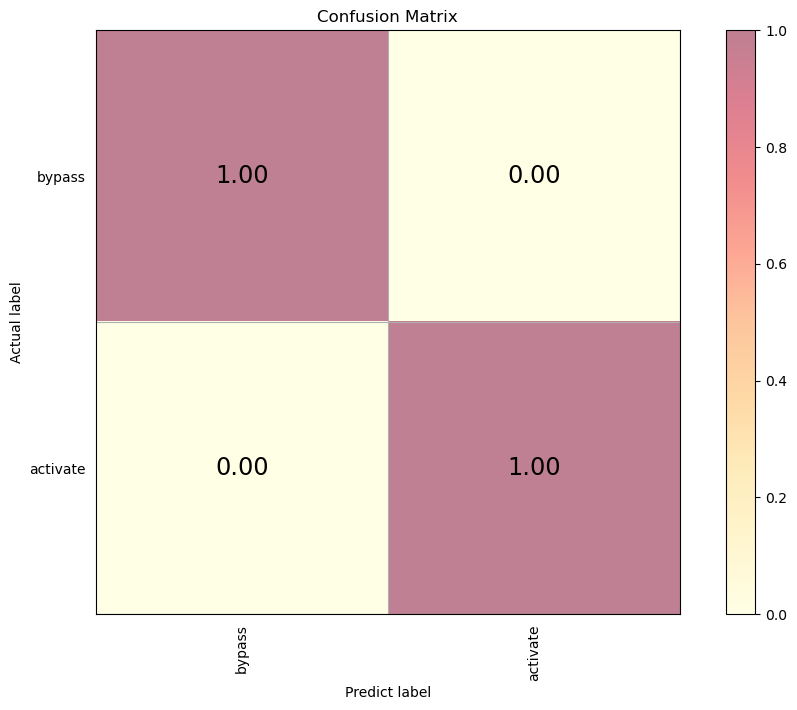

[[387  12]
 [  2 424]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       399
           1       0.97      1.00      0.98       426

    accuracy                           0.98       825
   macro avg       0.98      0.98      0.98       825
weighted avg       0.98      0.98      0.98       825



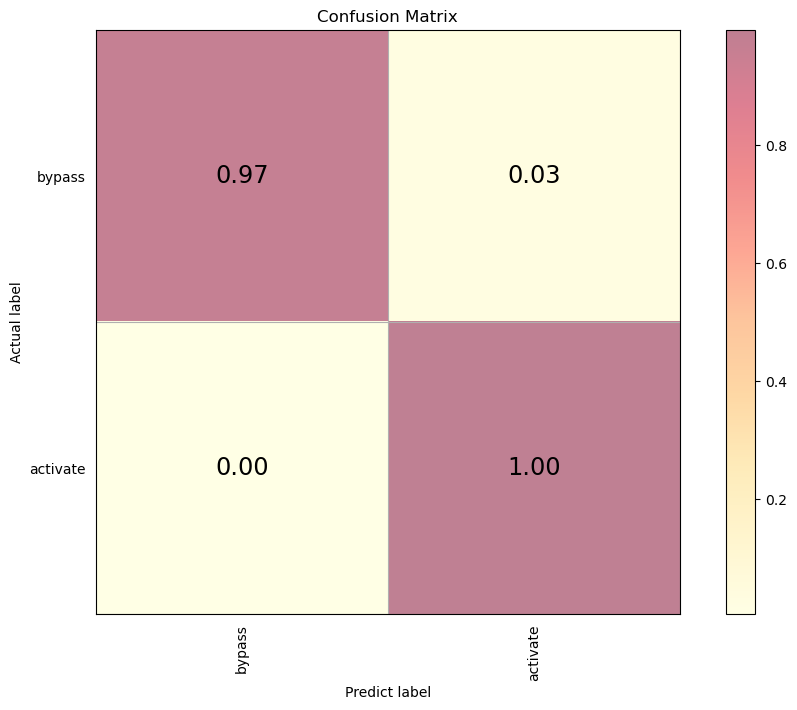

[[342  33]
 [ 11 439]]
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       375
           1       0.93      0.98      0.95       450

    accuracy                           0.95       825
   macro avg       0.95      0.94      0.95       825
weighted avg       0.95      0.95      0.95       825



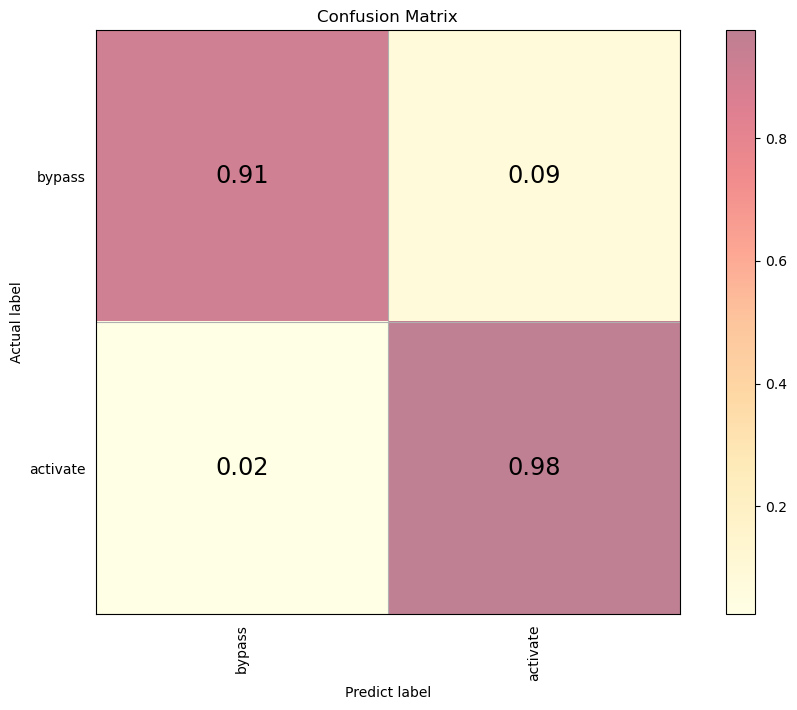

[[372   6]
 [  6 441]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       378
           1       0.99      0.99      0.99       447

    accuracy                           0.99       825
   macro avg       0.99      0.99      0.99       825
weighted avg       0.99      0.99      0.99       825



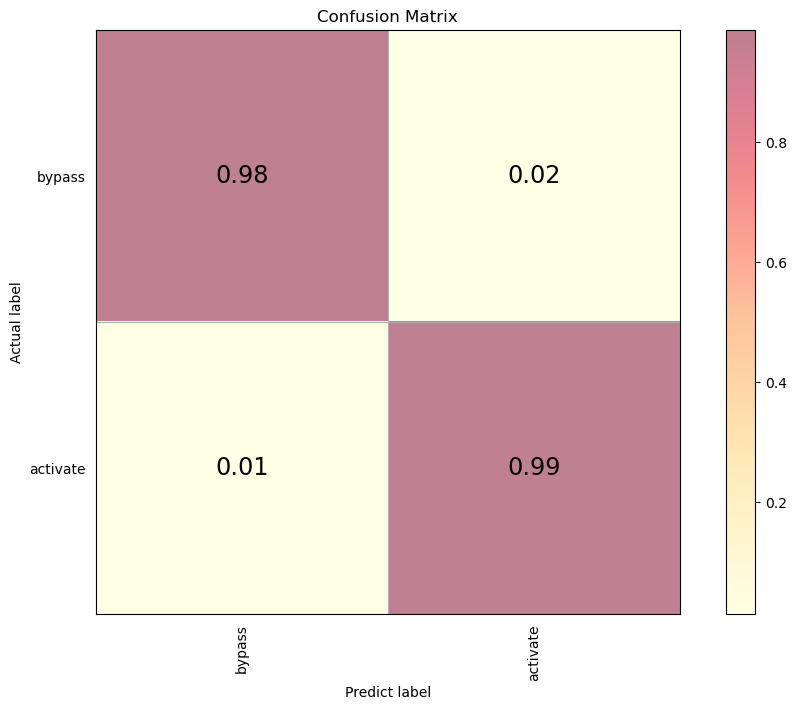

[[391   3]
 [  0 431]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       394
           1       0.99      1.00      1.00       431

    accuracy                           1.00       825
   macro avg       1.00      1.00      1.00       825
weighted avg       1.00      1.00      1.00       825



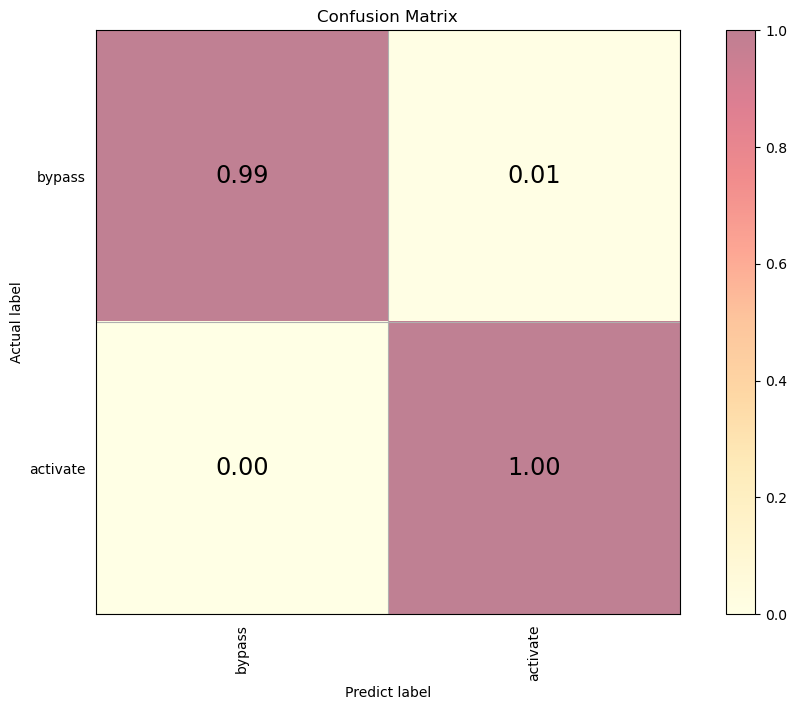

In [45]:
from sklearn.metrics import confusion_matrix, classification_report
from src.util import plot_confusion_matrix

labels_ID = ['bypass', 'activate']
EFFECT_MAP = ["distortion", "chorus", "tremolo", "delay", "reverb"]

cnn = model.Classifier().to(device)

state_dict = torch.load(WEIGHTS_FILE)
cnn.load_state_dict(state_dict)

_, _, log = train.test(cnn, val_dataloader, device)

for i in range(5):
    expected = []
    predicted = []
    for index, data in enumerate(log[i]):
        predicted.append(data[1])
        expected.append(data[2])
    mat_con = confusion_matrix(y_true=expected, y_pred=predicted)
    print(mat_con)
    print(classification_report(expected, predicted))
    
    log_writer.add_figure("Confusion Matrix/" + EFFECT_MAP[i],
                          plot_confusion_matrix(mat_con, title='Confusion Matrix', classes=labels_ID))

log_writer.close()